In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import nengo
import scipy.signal
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import seaborn
import sys
sys.path.append('../cedar_utils/')
from cedar_modules import AbsSigmoid, GaussKernel, BoxKernel, pad_and_convolve
from cedar_modules import one_dimensional_peak, two_dimensional_peak, three_dimensional_peak


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# The NeuralField class here is a copy of the NeuralField class in the cedar_modules.py 
# file with the addition of a probes attribute to probe different parts of a neural 
# field during its simulation

class NeuralField(object):
    ''' Neural Field class similar to the Neural Field used by cedar.
        Implements the Neural Field equation of Dynamic Field theory.
        
        Paramters
        ---------
        sizes : list of ints
            Size per dimension
        h : int or float
            Resting level of the NeuralField
        tau : int or float
            Time scale parameter
        kernel : GaussKernel or BoxKernel instance or list of two of these
            Kernel instance (or instances) that is used for the convolution
        c_glob : int or float, optional
            Global inhibition parameter, determines the strength of global
            inhibition
        nonlinearity : callable, optional
            Sigmoid function callable that returns the sigmoid values
            when called on some input
        border_type : {'zero-filled borders', 'cyclic'}, optional
            Border type that should be used for the padding in the 
            convolution
        input_noise_gain : int or float, optional
            Sets the strength of the global noise
        name : NoneType or str, optional
            Name to use for the nengo.Node instance

        Attributes
        ----------
        u : array_like
            Activation of the NeuralField
        kernel_matrix : array_like or float
            Kernel values 
        node : nengo.Node instance
            Node instance that takes care of the actual computations
            of the NeuralField. Only created after calling method 
            `make_node()`
        
        Notes
        -----
        The dimensionality of the Neural Field is inferred from the number
        of elements in the sizes parameter. 
    '''
    def __init__(self, 
                 sizes, 
                 h, 
                 tau, 
                 kernel, 
                 c_glob=1, 
                 nonlinearity=AbsSigmoid(beta=100),
                 border_type='zero-filled borders',
                 input_noise_gain=0.1,
                 name=None):
        self.u = np.ones(sizes) * h
        self.h = h
        self.tau = tau
        self.sizes = sizes
        self.c_glob = c_glob
        self.nonlinearity = nonlinearity
        self.border_type = border_type
        self.input_noise_gain = input_noise_gain
        
        # TODO: assertion not working anymore, since kernel can also be list now
        # assert (kernel.dims == len(sizes) or (len(sizes) == 0 and kernel.dims == 1)), \
        #         "Kernel must have same number of dimensions as Neural Field!"
        self.kernel = kernel
        
        # add kernels? other option would be to convolve with both kernels
        # in the update step
        # TODO: move this to outside NeuralField initialization
        if type(kernel) == list:
            km1 = kernel[0]()
            km2 = kernel[1]()
            if km1.shape == km2.shape:
                self.kernel_matrix = km1 + km2
            else:
                k_big = km1 if km1.shape[0] > km2.shape[0] else km2
                k_small = km1 if km1.shape[0] < km2.shape[0] else km2

                k_mask = np.zeros(k_big.shape)
                i_start = (k_big.shape[0]-k_small.shape[0])//2
                i_end = i_start + k_small.shape[0]
                if len(k_big.shape) == 1:
                    k_mask[i_start:i_end] = k_small
                elif len(k_big.shape) == 2:
                    k_mask[i_start:i_end, i_start:i_end] = k_small
                elif len(k_big.shape) == 3:
                    k_mask[i_start:i_end,i_start:i_end,i_start:i_end] = k_small
                self.kernel_matrix = k_big + k_mask
                       
        else:
            self.kernel_matrix = kernel()
        self.name = name
        self.probes = {"sigmoided activation": [],
                       "lateral interaction": [],
                       "activation": [],
                       "sigmoided sum": []}
        
    
    def update_cyclic(self, stim, pad_width):
        ''' Update method for `border_type` cyclic

            Parameters
            ----------
            stim : array_like
                Input to the NeuralField
            pad_width : tuple of ints
                Pad width on both sides of the input

            Returns
            -------
            array_like
                Updated activation of the NeuralField after one step of 
                the neural field equation was applied
        '''
        a = self.nonlinearity(self.u)
        self.probes["sigmoided activation"].append(a)
        recurr = pad_and_convolve(a, self.kernel_matrix, pad_width)
        self.probes["lateral interaction"].append(recurr)
        self.u += (-self.u + self.h + self.c_glob * np.sum(a) + recurr + stim)/self.tau + \
                  (self.input_noise_gain * np.random.randn(*self.sizes)) / self.tau 
        self.probes["activation"].append(np.array(self.u))
        self.probes["sigmoided sum"].append(np.sum(a))
        return self.u

    def update_zeros(self, stim):
        ''' Update method for `border_type` zero-filled borders

            Parameters
            ----------
            stim : array_like
                Input to the NeuralField
            
            Returns
            -------
            array_like
                Updated activation of the NeuralField after one step of 
                the neural field equation was applied
        '''
        a = self.nonlinearity(self.u)
        self.probes["sigmoided activation"].append(a)
        recurr = scipy.signal.convolve(a, self.kernel_matrix, mode='same')
        self.probes["lateral interaction"].append(recurr)
        self.u += (-self.u + self.h + self.c_glob * np.sum(a) + recurr + stim)/self.tau + \
                  (self.input_noise_gain * np.random.randn(*self.sizes)) / self.tau 
        self.probes["activation"].append(np.array(self.u))
        self.probes["sigmoided sum"].append(np.sum(a))
        return self.u


    def make_node(self):
        ''' Creates a nengo.Node() instance that takes care of the 
            NeuralField computations. It uses one of the above update
            methods for its update in each time step. 
        '''
        if self.border_type == 'zero-filled borders':
            # call convolve only update
            update = lambda t, x: self.update_zeros(x.reshape(self.sizes)).flatten()
        else:
            # bordertype is cyclic, need pad_and_convolve update
            # the 1 that is used as the kernel_width for 0-dimensional kernels is not really used
            # in later computations but needs to be specified here, otherwise, the shape[0] would
            # throw an error
            kernel_width = self.kernel_matrix.shape[0] if self.kernel_matrix.shape != () else 1
            pad_width_f = kernel_width//2
            pad_width_b = kernel_width//2 if kernel_width % 2 == 1 else kernel_width//2 - 1 
            pad_width = (pad_width_f, pad_width_b)

            update = lambda t, x: self.update_cyclic(x.reshape(self.sizes),
                                                     pad_width).flatten()

        if self.name is not None:
            self.node = nengo.Node(update,
                          size_in=int(np.product(self.sizes)), 
                          size_out=int(np.product(self.sizes)),
                          label=self.name)
        else:
            self.node = nengo.Node(update,
                          size_in=int(np.product(self.sizes)), 
                          size_out=int(np.product(self.sizes)))

In [3]:
dim = 0

sim_time = 0.2
c_glob = 0
tau = 10
h = -5
noise = 0
border_type = "cyclic"

if dim == 0:
    kernel_ampl = 2
#     kernel = BoxKernel(amplitude=kernel_ampl)
    kernel = GaussKernel(c=2, sigma=3, dims=0, normalize=False)
    sizes = [] 
    tau = tau
    
elif dim == 1:
    sizes = [50]
    kernel_ampl = 1
    kernel_std = 3
    kernel_dims = 1
    normalize = True
    kernel = GaussKernel(c=kernel_ampl, sigma=kernel_std, dims=kernel_dims, normalize=normalize)
    
elif dim == 2:
    sizes = [50,50]
    kernel_ampl = 2
    kernel_std = 5
    kernel_dims = 2
    normalize = True
    kernel = GaussKernel(c=kernel_ampl, sigma=kernel_std, dims=kernel_dims, normalize=normalize)
    
elif dim == 3:
    sizes = [50,50,50]
    kernel_ampl = 1
    kernel_std = 5
    kernel_dims = 3
    normalize = True
    kernel = GaussKernel(c=kernel_ampl, sigma=kernel_std, dims=kernel_dims, normalize=normalize)
    
field = NeuralField(sizes=sizes, h=h, tau=tau, c_glob=c_glob, kernel=kernel, border_type=border_type, 
                    input_noise_gain=noise, nonlinearity=AbsSigmoid())            

In [4]:
model = nengo.Network()
with model:
    
    if dim == 0:
        s = nengo.Node(4.9)
    elif dim == 1:
        s = nengo.Node(list(one_dimensional_peak(5,std=5,a=6.5,size=50).flatten()))
    elif dim == 2:
        s = nengo.Node(list(two_dimensional_peak(p=[5,5],std=[5,5],a=6.5,size=[50,50]).flatten()))
    elif dim == 3:
        s = nengo.Node(list(three_dimensional_peak(p=[5,5,5],std=[8,8,8],a=6.5,size=[50,50,50]).flatten()))
    
    field.make_node()
    u = field.node
    
    nengo.Connection(s, u)
                                                      
    activation_probe = nengo.Probe(u)
    external_input_probe = nengo.Probe(s)
    
sim = nengo.Simulator(model)
with sim:
    sim.run(sim_time)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

In [5]:
# print sum(sigmoided activation) after convergence
# for c_glob=0 it is 1113 for cedar
print(field.probes['sigmoided sum'][-1])

0.997374982355896


# Plot activation, sigmoided activation and lateral interaction

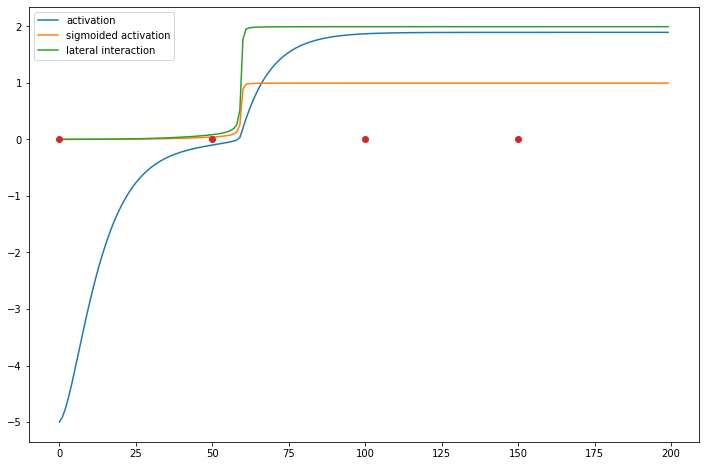

In [6]:
# different kind of plots for different dimensionalities

if dim == 0:
    plt.figure(figsize=(12,8))
    plt.plot(sim.data[activation_probe], label='activation')
    plt.plot(field.probes["sigmoided activation"], label='sigmoided activation')
    plt.plot(field.probes["lateral interaction"], label='lateral interaction')
    plt.plot(np.arange(0,int(sim_time*1000),50), [0]*int((sim_time*1000)//50), 'o')
    plt.legend()
    
elif dim == 1:
    num_images = 10
    fig, axs = plt.subplots(3, num_images, sharex="col", sharey="row", figsize=(24,6), gridspec_kw={"hspace": 0.25})

    axs[0,0].set_title('Activation', fontsize=15)
    axs[0,0].set_ylim([np.min(field.probes["activation"])-0.1,np.max(field.probes["activation"])+0.1])
    axs[1,0].set_title('Sigmoided activation', fontsize=15)
    axs[1,0].set_ylim([np.min(field.probes["sigmoided activation"])-0.1,
                       np.max(field.probes["sigmoided activation"])+0.1])
    axs[2,0].set_title('Lateral interaction', fontsize=15)
    axs[2,0].set_ylim([np.min(field.probes["lateral interaction"])-0.1,
                       np.max(field.probes["lateral interaction"])+0.1])
    
    for i in range(num_images):
        ind = int(len(field.probes["activation"])/num_images)
#         ind = i*100
        
        axs[0,i].plot(field.probes["activation"][ind])
        axs[1,i].plot(field.probes["sigmoided activation"][ind])
        axs[2,i].plot(field.probes["lateral interaction"][ind])
        
elif dim == 2:
    num_images = 10
    fig, axs = plt.subplots(3, num_images, figsize=(24,6), gridspec_kw={"hspace": 0.1, "wspace": 0.5})
    
    axs[0,0].set_title('Activation', fontsize=15)
    axs[1,0].set_title('Sigmoided activation', fontsize=15)
    axs[2,0].set_title('Lateral interaction', fontsize=15)
    
    plt.setp(axs, xticks=[], yticks=[])
    
    for i in range(num_images):
        ind = i*10
        
        im_ac = axs[0,i].imshow(sim.data[activation_probe][ind].reshape(sizes), cmap='jet')
        im_sa = axs[1,i].imshow(field.probes["sigmoided activation"][ind], cmap='jet')
        im_li = axs[2,i].imshow(field.probes["lateral interaction"][ind], cmap='jet')
    
        act_min, act_max = np.min(sim.data[activation_probe][ind]), np.max(sim.data[activation_probe][ind])
        sa_min, sa_max = np.min(field.probes["sigmoided activation"][ind]), np.max(field.probes["sigmoided activation"][ind])
        li_min, li_max = np.min(field.probes["lateral interaction"][ind]), np.max(field.probes["lateral interaction"][ind])
        
        divider = make_axes_locatable(axs[0,i])
        cax_ac = divider.append_axes('right', size="10%", pad=0.05)
        fig.colorbar(im_ac, cax_ac, ticks=[act_min, act_max])

        divider = make_axes_locatable(axs[1,i])
        cax_sa = divider.append_axes('right', size="10%", pad=0.05)
        fig.colorbar(im_sa, cax_sa, ticks=[sa_min, sa_max])

        divider = make_axes_locatable(axs[2,i])
        cax_li = divider.append_axes('right', size="10%", pad=0.05)
        fig.colorbar(im_li, cax_li, ticks=[li_min, li_max])
    
elif dim == 3:
    # only plot at one point in time 
    time_ind = len(sim.data[activation_probe]) -1
    num_images = 10
    
    fig, axs = plt.subplots(3, num_images, figsize=(24,8), gridspec_kw={"hspace": 0.25})
    
    axs[0,0].set_title('Activation', fontsize=15)
    axs[1,0].set_title('Sigmoided activation', fontsize=15)
    axs[2,0].set_title('Lateral interaction', fontsize=15)
    act_min, act_max = np.min(sim.data[activation_probe][time_ind]), np.max(sim.data[activation_probe][time_ind])
    sa_min, sa_max = np.min(field.probes["sigmoided activation"][time_ind]), np.max(field.probes["sigmoided activation"][time_ind])
    li_min, li_max = np.min(field.probes["lateral interaction"][time_ind]), np.max(field.probes["lateral interaction"][time_ind])
    plt.setp(axs, xticks=[], yticks=[])
    
    for i in range(num_images):
        # just get the first 10 images, since the gaussian peak is at the beginning
        ind = i
        s0, s1, s2 = sizes[0], sizes[1], sizes[2]
        im_ac = axs[0,i].imshow(sim.data[activation_probe][time_ind][ind*s1*s2:ind*s1*s2+s1*s2].reshape(s1,s2), 
                                cmap='jet', vmin=act_min, vmax=act_max)
        im_sa = axs[1,i].imshow(field.probes["sigmoided activation"][time_ind][ind], cmap='jet', 
                                vmin=sa_min, vmax=sa_max)
        im_li = axs[2,i].imshow(field.probes["lateral interaction"][time_ind][ind], cmap='jet', 
                                vmin=li_min, vmax=li_max)
    
    fig.subplots_adjust(right=0.95)
    cax_ac = fig.add_axes([0.96, 0.667, 0.01, 0.211])
    cbar_ac = fig.colorbar(im_ac, cax_ac, ticks=[act_min, act_max])
    cbar_ac.ax.tick_params(labelsize=15)
    
    cax_sa = fig.add_axes([0.96, 0.397, 0.01, 0.211])
    cbar_sa = fig.colorbar(im_sa, cax_sa, ticks=[sa_min, sa_max])
    cbar_sa.ax.tick_params(labelsize=15)
    
    cax_li = fig.add_axes([0.96, 0.129, 0.01, 0.211])
    cbar_li = fig.colorbar(im_li, cax_li, ticks=[li_min, li_max])
    cbar_li.ax.tick_params(labelsize=15)
    
plt.show()

# Check noise

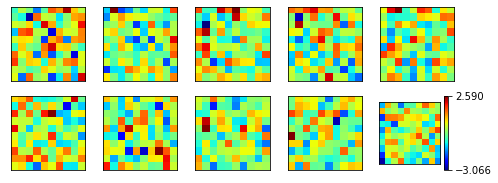

In [8]:
random_noise = np.random.randn(10,10,10)
rn_min = np.min(random_noise)
rn_max = np.max(random_noise)

plt.figure(figsize=(8,3))
for i in range(10):
    
    plt.subplot(2,5,i+1)
    plt.imshow(np.random.randn(10,10), cmap='jet', vmin=rn_min, vmax=rn_max)
    if i == 9:
        plt.colorbar(ticks=[rn_min, rn_max])
    plt.xticks([])
    plt.yticks([])